In [1]:
import re
import urllib

def extract_audio_identifier(url: str) -> tuple:
    parts = url.strip("/").split("/")
    return urllib.parse.unquote(parts[-2]), int(parts[-1])

# Data

In [2]:
from datasets import load_dataset
import pandas as pd

DATA_FILE = "sawadogosalif/MooreFRCollections_BibleOnlyText"
data = load_dataset(DATA_FILE, split="train").to_pandas()
data[["chapter", "page"]] = data["moore_source_url"].apply(
    lambda x: pd.Series(extract_audio_identifier(x))
)

BUCKET_NAME = "moore-collection"

c:\Users\sawal\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
tmp = data[(data.page==3) & (data.chapter=="Sɩngre")]

In [ ]:
from pydub import AudioSegment, silence


file_path = "C:/Users/sawal/Downloads/nwt_01_Ge_MM_03.mp3" #PAGE 3 du chapitre singré
audio = AudioSegment.from_file(file_path)


# EDA

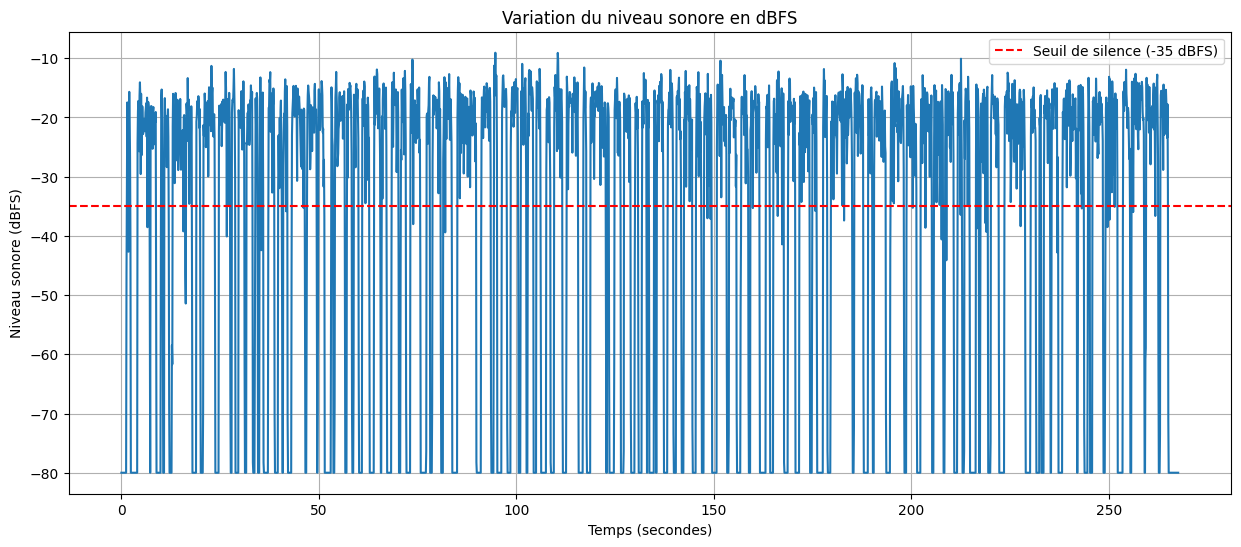

In [5]:
from pydub import AudioSegment
import numpy as np
import matplotlib.pyplot as plt
import array

segment_ms = 100
segments = [audio[i:i+segment_ms] for i in range(0, len(audio), segment_ms)]

dbfs_values = [segment.dBFS for segment in segments]

times = np.arange(len(dbfs_values)) * (segment_ms / 1000)

# Remplacer les valeurs -inf (silence total) par une valeur minimale pour l'affichage
min_dbfs = -80  
dbfs_values = [max(db, min_dbfs) if db != float('-inf') else min_dbfs for db in dbfs_values]

# Tracer le graphique
plt.figure(figsize=(15, 6))
plt.plot(times, dbfs_values)
plt.xlabel('Temps (secondes)')
plt.ylabel('Niveau sonore (dBFS)')
plt.title('Variation du niveau sonore en dBFS')
plt.grid(True)

silence_threshold = -35  # 
plt.axhline(y=silence_threshold, color='r', linestyle='--', label=f'Seuil de silence ({silence_threshold} dBFS)')
plt.legend()


# Segmentation

In [6]:
silence_thresh = -35
min_silence_len = 400

silences = silence.detect_silence(
    audio, silence_thresh=silence_thresh, min_silence_len=min_silence_len

)
silences = [(start, end) for start, end in silences]

In [7]:
start, segments = 0, []
segment_folder = "segments/"
for i, (silence_start, silence_end) in enumerate(silences):
    segment = audio[start:silence_start]
    filename = f"{segment_folder}segment_{i+1}.wav"
    segment.export(filename, format="wav")
    print(f"Segment saved: {filename}")
    start = silence_end
    segments.append(filename)

Segment saved: segments/segment_1.wav
Segment saved: segments/segment_2.wav
Segment saved: segments/segment_3.wav
Segment saved: segments/segment_4.wav
Segment saved: segments/segment_5.wav
Segment saved: segments/segment_6.wav
Segment saved: segments/segment_7.wav
Segment saved: segments/segment_8.wav
Segment saved: segments/segment_9.wav
Segment saved: segments/segment_10.wav
Segment saved: segments/segment_11.wav
Segment saved: segments/segment_12.wav
Segment saved: segments/segment_13.wav
Segment saved: segments/segment_14.wav
Segment saved: segments/segment_15.wav
Segment saved: segments/segment_16.wav
Segment saved: segments/segment_17.wav
Segment saved: segments/segment_18.wav
Segment saved: segments/segment_19.wav
Segment saved: segments/segment_20.wav
Segment saved: segments/segment_21.wav
Segment saved: segments/segment_22.wav
Segment saved: segments/segment_23.wav
Segment saved: segments/segment_24.wav
Segment saved: segments/segment_25.wav
Segment saved: segments/segment_26

# Alignement

In [8]:
from pathlib import Path

def get_audio_paths(folder: str) -> list[str]:
        def extract_number(file_path: str) -> int:
            match = re.search(r"segment_(\d+)", file_path)
            return int(match.group(1)) if match else float("inf")
        audio_paths = list(Path(folder).glob("*.wav"))
        audio_paths = [audio_path.as_posix() for audio_path in audio_paths]
        audio_paths = sorted(audio_paths, key=extract_number)
        return audio_paths

paths =get_audio_paths("segments")[2:]

In [9]:

import re
import pandas as pd

def clean_and_split(text):
    text = re.sub(r'^\d+\s*', '', text)
    for char in ["+", "”", "“", "’", "’”"]:
        text = text.replace(char, "")
    parts = re.split(r'[:;,.?]+', text)
    return [part.strip() for part in parts if part.strip()]



lists = tmp["moore_verse_text"].apply(clean_and_split).to_list()
transcriptions = sum(lists, [])

In [10]:
# Remarque impotante

# SI DEBUT DE CHAPITR
    # premiers audios ilissibe
    # deuxieme audio : annonce du chapitre
    # troisieme audio : annonce de la page
# else:
   # premiers audios ilissibe
    # deuxième audio : annonce de la page


if len(transcriptions) == len(paths):
        data_dict = {
        "audio": paths,
        "transcript": transcriptions
    }
from datasets import Dataset, Audio, Features, Value, DatasetDict
    
dataset = Dataset.from_dict(data_dict)
features = Features({
        "audio": Audio(sampling_rate=48000),  # Spécifier la fréquence d'échantillonnage à 48kHz
        "transcript": Value("string")
    })
dataset = dataset.cast(features)

durations  = []
for example in dataset:
    audio_path = example["audio"]['path']
    audio = AudioSegment.from_file(audio_path)
    duration = len(audio) / 1000.0  # Convertir
    durations.append(duration)
print(sum(durations))
dataset = dataset.add_column("duration", durations)
print(dataset)

Casting the dataset: 100%|██████████| 94/94 [00:00<00:00, 7230.50 examples/s]


166.421
Dataset({
    features: ['audio', 'transcript', 'duration'],
    num_rows: 94
})




#### Data Fields
The dataset includes the following fields:

audio: Audio file containing the spoken Bible passage (48kHz sampling rate)
full_text: Complete transcription of the audio passage in Bambara
duration: Length of the audio clip in seconds

#### Usage

1. Speech Recognition: Training ASR models for Moore
2. Text-to-Speech: Development of TTS systems for Moore
3. Speech Analysis: Studying prosody and phonetics of Moore
4. Recherche linguistique : Analyse approfondie des structures syntaxiques, lexicales et phonétiques spécifiques au Mooré, pour enrichir les études linguistiques.

#### Loading the Dataset
```python
from datasets import load_dataset
dataset = load_dataset("faso-ai/bible-moore-audio", "raw")
```

#### Additional Information
- Source: https://www.jw.org/mos/d-s%E1%BA%BDn-yiisi/biible/nwt/books/
- Prepared  by: @sawadogosalif and @konkinit at Faso-AI
- Total Duration: 
- Audio Format: WAV files sampled at 48kHz
- Language: Moore

